In [1]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

In [2]:
# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, mCalData, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)
    data = data * mCalData
    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, nfft=2**8):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags):
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    max_idxs = max_idxs.astype(int)
    target_idx = int(np.mean(max_idxs))

    return target_idx

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

In [74]:
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)

num_rx = 4
num_tx = 1

f_tags = np.array([156, 250, 313, 625])
# f_tags = np.array([183, 337, 250, 127])


# Microdisplacement helper functions

# Antenna-wise microdisplacement helper functions  

In [3]:
# what does this do? 
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

# Need to check if I can do this antenna_wise or not
def get_period_antenna_wise(Igrid, Qgrid, num_rx):
    freqIndex = []
    for rx_idx in range(num_rx):
        Ipeaks, _ = signal.find_peaks((Igrid[:,rx_idx]))
        Qpeaks, _ = signal.find_peaks((Qgrid[:,rx_idx]))

        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Qpeaks)

        freqIndex.extend(per1temp)
        freqIndex.extend(per2temp)

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends
    else:
        period = 0  # Handle case where no peaks are found
    return period

def get_displacement_antenna_wise(Igrid, Qgrid, range_subset_width, num_rx):
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (num_rx, 1))

    period = get_period_antenna_wise(Igrid, Qgrid, num_rx)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((num_rx, len(phi)))
    autoCorr2b = np.zeros((num_rx, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (num_rx, 1))
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (num_rx, 1))
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return unwrapPi(angles)

# Microdisplacement Processing 

In [4]:
def find_doppler_bins(f_tags, doppler_freqs):
    search_f = np.concatenate((f_tags, -f_tags))
    bins = []

    for f in search_f: 
        err = np.abs(f - doppler_freqs)
        bins.append(np.argmin(err))

    bins_left = bins[len(f_tags):]
    bins_right = bins[:len(f_tags)]

    return bins_left, bins_right

In [ ]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/straight_200cm_H-24GHz.pickle', 'rb'))
data_raw = data['Data']

nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
# f_tags = np.array([183, 337, 250, 127])
f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 50 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

# Instead of frames, do this across antennas (num_rx instead of n_frames)
Igrid = np.zeros((4, range_subset_width, num_rx))
Qgrid = np.zeros((4, range_subset_width, num_rx))
Pgrid = np.zeros((4, range_subset_width, num_rx))
dopgrid = np.zeros((nfft, num_rx))

# Do all this for a single frame
frame_no = 10 
frame = data_raw[:, frame_no ,:]
data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
RD = get_RD(RP)        # 256 x 256 x 4 

range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

side1 = 0
side2 = 1
side3 = 2
side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

for i in range(len(f_tags)):
    # Take the range subset for all angles 
    RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i], :]     # range subset x doppler index x all angles 
    RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i], :]   
    
    I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
    Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

    # Take the phase across the range subset 
    phase = np.atan(I_tag/Q_tag) 

    Igrid[i] = normalize(np.abs((I_tag)))
    Qgrid[i] = normalize(np.abs((Q_tag)))
    Pgrid[i] = normalize(np.abs(phase))

# phase values for each frequency
unwrappedDist = get_displacement_antenna_wise(Igrid[0], Qgrid[0], range_subset_width, num_rx)           # face A
unwrappedDist2 = get_displacement_antenna_wise(Igrid[1], Qgrid[1], range_subset_width, num_rx)          # face B 
unwrappedDist3 = get_displacement_antenna_wise(Igrid[2], Qgrid[2], range_subset_width, num_rx)          # face C
unwrappedDist4 = get_displacement_antenna_wise(Igrid[3], Qgrid[3], range_subset_width, num_rx)          # face D

# Plotting

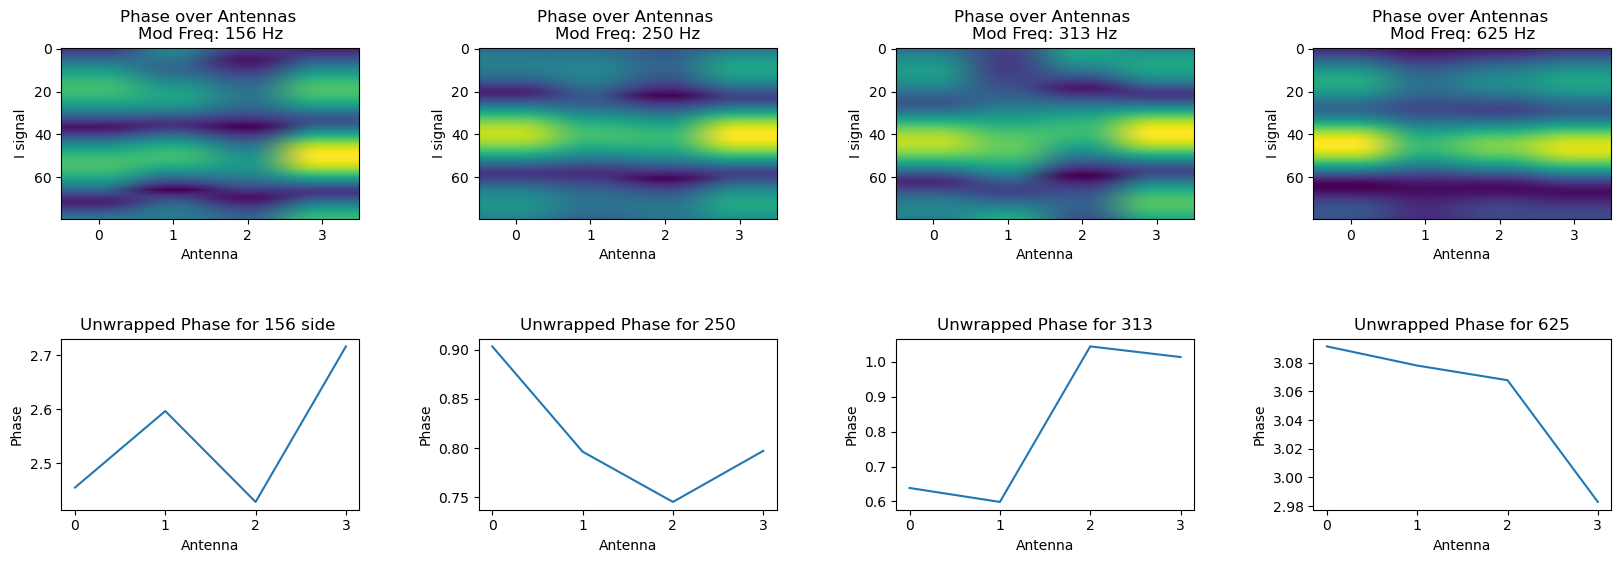

In [78]:
# Initialize plot

fig, ((ax2, ax3, ax4, ax5), (ax7, ax8, ax9, ax10)) = plt.subplots(2, 4, figsize=(20, 6))
plt.subplots_adjust(hspace= 0.7, wspace = 0.4)


modfreq1 = f_tags[0]
modfreq2 = f_tags[1]
modfreq3 = f_tags[2]
modfreq4 = f_tags[3]

ax2.set_title("Phase over Antennas \nMod Freq: " + str(modfreq1) + " Hz")
ax2.set_xlabel("Antenna")
ax2.set_ylabel("I signal")
ax2.set_xticks([0, 1, 2, 3])
ax2.imshow(Igrid[0], aspect='auto')

ax3.set_title("Phase over Antennas \nMod Freq: " + str(modfreq2) + " Hz")
ax3.set_xlabel("Antenna")
ax3.set_ylabel("I signal")
ax3.set_xticks([0, 1, 2, 3])
ax3.imshow(Igrid[1], aspect='auto')

ax4.set_title("Phase over Antennas \nMod Freq: " + str(modfreq3) + " Hz")
ax4.set_xlabel("Antenna")
ax4.set_ylabel("I signal")
ax4.set_xticks([0, 1, 2, 3])
ax4.imshow(Igrid[2], aspect='auto')

ax5.set_title("Phase over Antennas \nMod Freq: " + str(modfreq4) + " Hz")
ax5.set_xlabel("Antenna")
ax5.set_ylabel("I signal")
ax5.set_xticks([0, 1, 2, 3])
ax5.imshow(Igrid[3], aspect='auto')

ax7.set_title("Unwrapped Phase for "+str(modfreq1) +" side ")
ax7.set_ylabel("Phase")
ax7.set_xlabel("Antenna")
ax7.set_xticks([0, 1, 2, 3])
ax7.plot(unwrappedDist)


ax8.set_title("Unwrapped Phase for "+str(modfreq2))
ax8.set_ylabel("Phase")
ax8.set_xlabel("Antenna")
ax8.set_xticks([0, 1, 2, 3])
ax8.plot(unwrappedDist2)

ax9.set_title("Unwrapped Phase for "+str(modfreq3))
ax9.set_ylabel("Phase")
ax9.set_xlabel("Antenna")
ax9.set_xticks([0, 1, 2, 3])
ax9.plot(unwrappedDist3)

ax10.set_title("Unwrapped Phase for "+str(modfreq4))
ax10.set_ylabel("Phase")
ax10.set_xlabel("Antenna")
ax10.set_xticks([0, 1, 2, 3])
ax10.plot(unwrappedDist4)


#phase increase, when closer, decrease when farther
phase_diff1 = (unwrappedDist2)- unwrappedDist3
phase_diff2 = (unwrappedDist2)- (unwrappedDist)
plt.show()

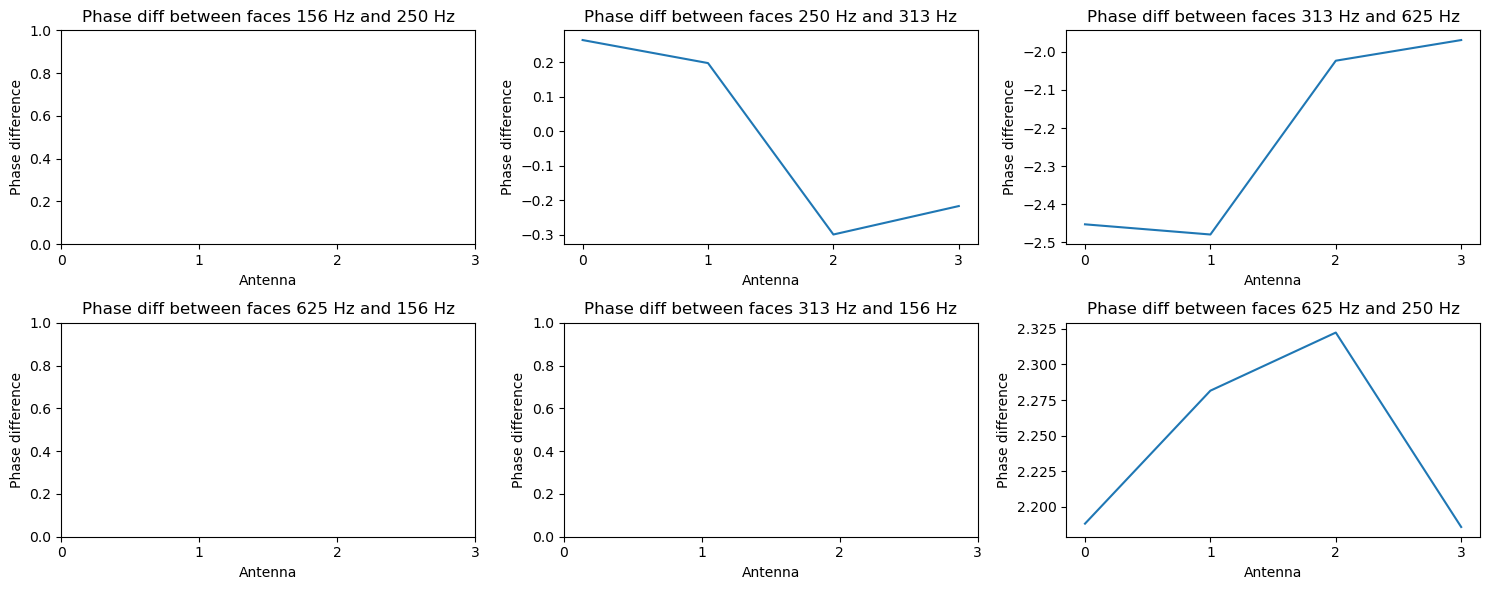

In [79]:
# Taking differences over the same antennas 
# -- cannot take difference over different antennas as that would incur extra dcos(theta) phase shift

# phase_diff1 = unwrappedDist - unwrappedDist2
phase_diff2 = unwrappedDist2 - unwrappedDist3
phase_diff3 = unwrappedDist3 - unwrappedDist4
# phase_diff4 = unwrappedDist4 - unwrappedDist
# phase_diff5 = unwrappedDist3 - unwrappedDist
phase_diff6 = unwrappedDist4 - unwrappedDist2

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (15, 6))

ax1.set_title(f"Phase diff between faces {modfreq1} Hz and {modfreq2} Hz")
ax1.set_xlabel("Antenna")
ax1.set_ylabel("Phase difference")
ax1.set_xticks([0, 1, 2, 3])
# ax1.plot(phase_diff1)

ax2.set_title(f"Phase diff between faces {modfreq2} Hz and {modfreq3} Hz")
ax2.set_xlabel("Antenna")
ax2.set_ylabel("Phase difference")
ax2.set_xticks([0, 1, 2, 3])
ax2.plot(phase_diff2)

ax3.set_title(f"Phase diff between faces {modfreq3} Hz and {modfreq4} Hz")
ax3.set_xlabel("Antenna")
ax3.set_ylabel("Phase difference")
ax3.set_xticks([0, 1, 2, 3])
ax3.plot(phase_diff3)

ax4.set_title(f"Phase diff between faces {modfreq4} Hz and {modfreq1} Hz")
ax4.set_xlabel("Antenna")
ax4.set_ylabel("Phase difference")
ax4.set_xticks([0, 1, 2, 3])
# ax4.plot(phase_diff4)

ax5.set_title(f"Phase diff between faces {modfreq3} Hz and {modfreq1} Hz")
ax5.set_xlabel("Antenna")
ax5.set_ylabel("Phase difference")
ax5.set_xticks([0, 1, 2, 3])
# ax5.plot(phase_diff5)

ax6.set_title(f"Phase diff between faces {modfreq4} Hz and {modfreq2} Hz")
ax6.set_xlabel("Antenna")
ax6.set_ylabel("Phase difference")
ax6.set_xticks([0, 1, 2, 3])
ax6.plot(phase_diff6)

plt.tight_layout()
plt.show()

In [80]:
np.mean(phase_diff2)

np.float64(-0.013351768777756623)

In [81]:
np.mean(phase_diff3)

np.float64(-2.2311198326713013)

In [82]:
del_phi = np.mean(phase_diff6)

In [83]:
lam = c/(24.125e9)
del_r = (lam / (4 * np.pi)) * del_phi
print(del_r)

0.002206242227979275


In [84]:
# CalDat is an 8-long array, not sure which 4 to take: taking the first 4
CalDat = data['CalDat'][:4]
# print(CalDat[:4])

In [85]:
# replicate along axes (1, Cfg.FrmMeasSiz, N-1)
Cfg = data['Cfg']

# -- N: number of samples (256)
# Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, Cfg['FrmMeasSiz'], N-1))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 

In [86]:
rep.shape

(4, 256, 127)

In [87]:
mCalData = np.transpose(rep, (2, 1, 0))

In [88]:
mCalData.shape

(127, 256, 4)

In [89]:
lam

0.012352331606217617

In [5]:
def get_del_r(filename, frame_no=10, f_tags = np.array([156, 250, 313, 625])):
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']

    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the first 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))
    
    range_subset_width = 80 
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    # Instead of frames, do this across antennas (num_rx instead of n_frames)
    Igrid = np.zeros((4, range_subset_width, num_rx))
    Qgrid = np.zeros((4, range_subset_width, num_rx))
    Pgrid = np.zeros((4, range_subset_width, num_rx))
    dopgrid = np.zeros((nfft, num_rx))

    # Do all this for a single frame 
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    side1 = 0
    side2 = 1
    side3 = 2
    side4 = 3
    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0   

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i], :]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i], :]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i] = normalize(np.abs((I_tag)))
        Qgrid[i] = normalize(np.abs((Q_tag)))
        Pgrid[i] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement_antenna_wise(Igrid[0], Qgrid[0], range_subset_width, num_rx)           # A
    phaseB = get_displacement_antenna_wise(Igrid[1], Qgrid[1], range_subset_width, num_rx)          # B 
    phaseC = get_displacement_antenna_wise(Igrid[2], Qgrid[2], range_subset_width, num_rx)          # C
    phaseD = get_displacement_antenna_wise(Igrid[3], Qgrid[3], range_subset_width, num_rx)          # D

    # Extract the phase differences from the unwrapped phases (assume that working with H polarization only)
    phase_diff1 = phaseB - phaseC           # Side B - Side C
    phase_diff2 = phaseC - phaseD           # Side C - Side D
    phase_diff3 = phaseD - phaseB           # Side D - Side B

    # Take mean of each 
    # return np.mean(phase_diff1), np.mean(phase_diff2), np.mean(phase_diff3)
    return phaseA, phaseB, phaseC, phaseD


In [91]:
filename = "/nas-data/soham/drone-landing/test_20cm_across_aoa_16_to_24deg-24GHz.pickle"

phase_array_1 = []
phase_array_2 = []
phase_array_3 = []

for i in range(2, 89):
    phase1, phase2, phase3 = get_del_r(filename, frame_no=i, f_tags = np.array([183, 337, 250, 127]))
    phase_array_1.append(phase1)
    phase_array_2.append(phase2)
    phase_array_3.append(phase3)

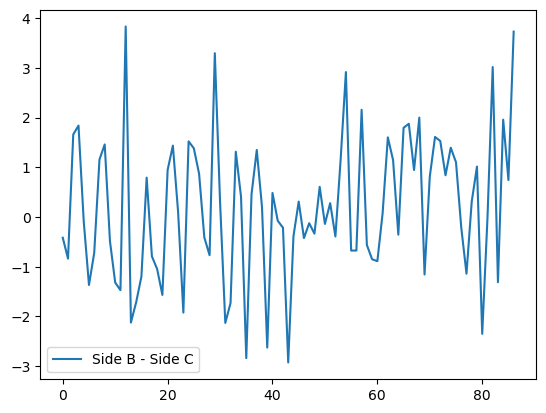

In [92]:
plt.plot(phase_array_1, label = 'Side B - Side C')
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.legend()
plt.show()

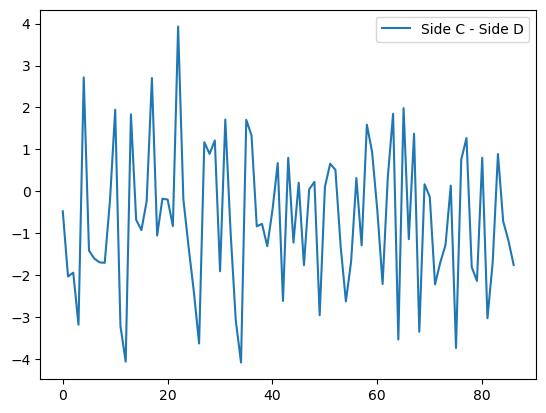

In [93]:
plt.plot(phase_array_2, label = 'Side C - Side D')
plt.legend()

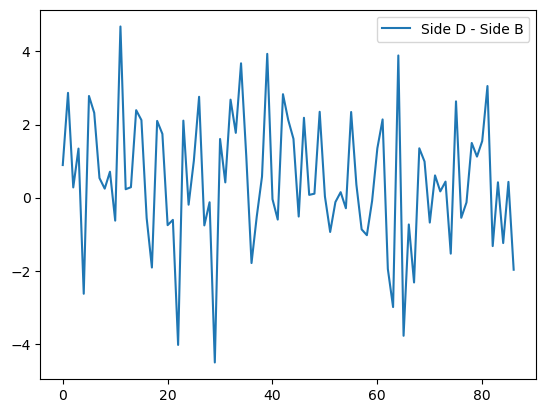

In [94]:
plt.plot(phase_array_3, label = 'Side D - Side B')
plt.legend()

In [3]:
c = 3e8
lam = c/(24.125e9)
lam

0.012435233160621761

In [4]:
lam/4

0.0031088082901554403

In [16]:
import numpy as np
h = 0.015 
theta_max = 30 #degrees
del_r_max = h/np.cos(theta_max*np.pi/180)

del_r_max

np.float64(0.01732050807568877)

In [ ]:
lam

0.012435233160621761

In [15]:
5/4 * lam

0.015544041450777202

In [25]:
filename = "/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle"

phase_array_1 = []
phase_array_2 = []
phase_array_3 = []

for i in range(2, 89):
    phase1, phase2, phase3 = get_del_r(filename, frame_no=i, f_tags = np.array([183, 337, 250, 127]))
    phase_array_1.append(phase1)
    phase_array_2.append(phase2)
    phase_array_3.append(phase3)

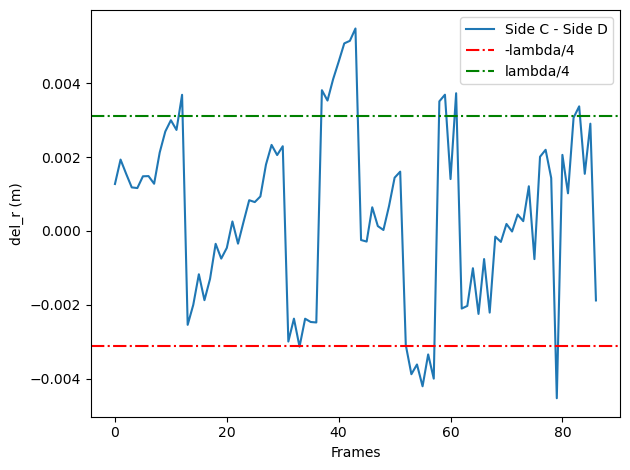

In [36]:
plt.plot( (lam / (2*np.pi)) * np.array(phase_array_2), label = 'Side C - Side D')
plt.axhline(-lam/4, linestyle='-.', color='r', label="-lambda/4")
plt.axhline(lam/4, linestyle='-.', color='g', label="lambda/4")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Frames")
plt.ylabel("del_r (m)")
plt.tight_layout()
plt.legend()
plt.show()

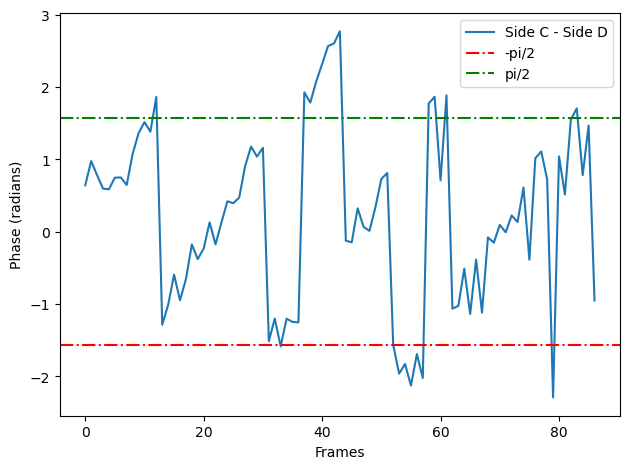

In [38]:
plt.plot( np.array(phase_array_2), label = 'Side C - Side D')
plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

In [39]:
AoAs = np.linspace(0, 8, 87)
del_rs = h/np.cos(AoAs*np.pi/180)
del_rs

array([0.015     , 0.01500002, 0.01500008, 0.01500018, 0.01500032,
       0.01500049, 0.01500071, 0.01500097, 0.01500127, 0.0150016 ,
       0.01500198, 0.01500239, 0.01500285, 0.01500334, 0.01500388,
       0.01500445, 0.01500506, 0.01500572, 0.01500641, 0.01500714,
       0.01500791, 0.01500872, 0.01500957, 0.01501046, 0.01501139,
       0.01501236, 0.01501337, 0.01501442, 0.01501551, 0.01501664,
       0.01501781, 0.01501902, 0.01502027, 0.01502155, 0.01502288,
       0.01502425, 0.01502566, 0.01502711, 0.01502859, 0.01503012,
       0.01503169, 0.01503329, 0.01503494, 0.01503663, 0.01503836,
       0.01504012, 0.01504193, 0.01504378, 0.01504566, 0.01504759,
       0.01504956, 0.01505157, 0.01505362, 0.0150557 , 0.01505783,
       0.01506   , 0.01506221, 0.01506446, 0.01506675, 0.01506908,
       0.01507145, 0.01507386, 0.01507632, 0.01507881, 0.01508134,
       0.01508392, 0.01508653, 0.01508919, 0.01509188, 0.01509462,
       0.0150974 , 0.01510021, 0.01510307, 0.01510597, 0.01510

In [54]:
phases = del_rs * ((2*np.pi) / lam)

In [55]:
phases = ( (phases + np.pi/2) % np.pi ) - np.pi/2

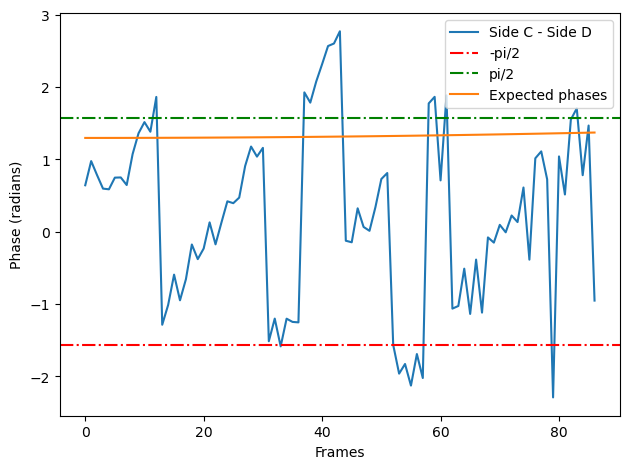

In [57]:
plt.plot( np.array(phase_array_2), label = 'Side C - Side D')
plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
plt.plot(phases, color='tab:orange', label="Expected phases")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

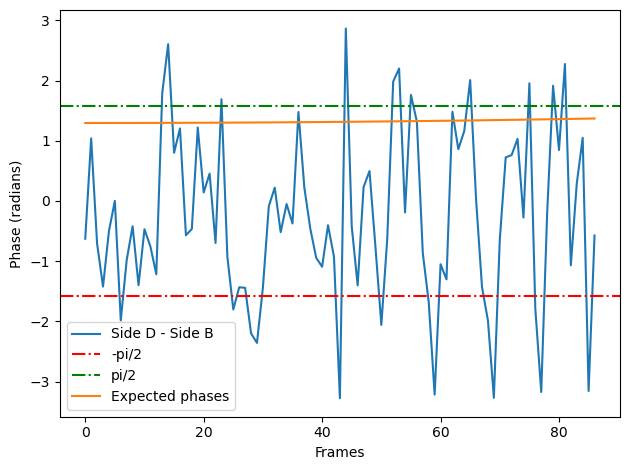

In [51]:
plt.plot( np.array(phase_array_3), label = 'Side D - Side B')
plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
plt.plot(phases, color='tab:orange', label="Expected phases")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

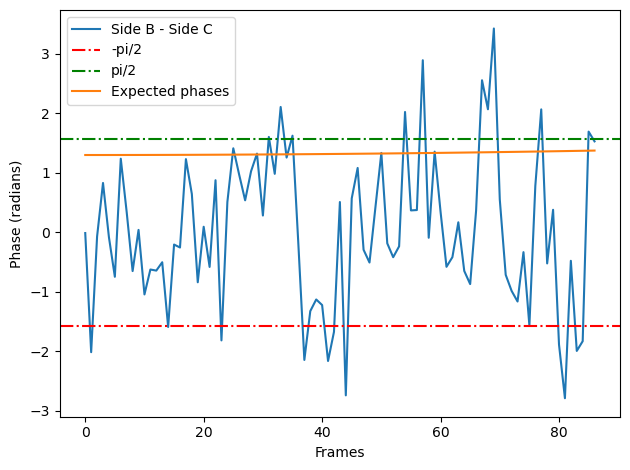

In [52]:
plt.plot( np.array(phase_array_1), label = 'Side B - Side C')
plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
plt.plot(phases, color='tab:orange', label="Expected phases")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

In [59]:
filename = "/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle"

phase_array_A = []
phase_array_B = []
phase_array_C = []
phase_array_D = []

for i in range(2, 89):
    phaseA, phaseB, phaseC, phaseD = get_del_r(filename, frame_no=i, f_tags = np.array([183, 337, 250, 127]))
    phase_array_A.append(phaseA)
    phase_array_B.append(phaseB)
    phase_array_C.append(phaseC)
    phase_array_D.append(phaseD)

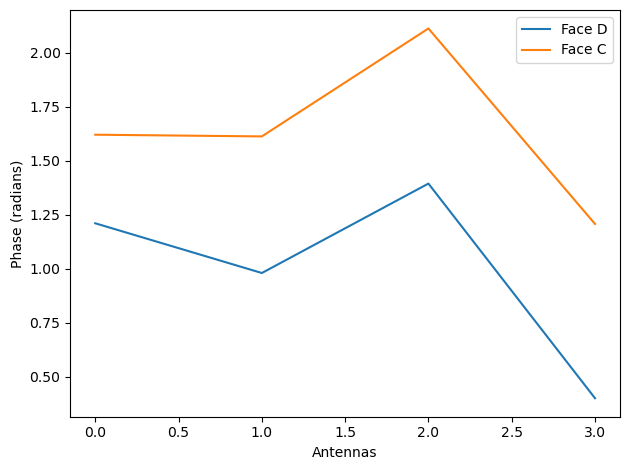

In [68]:
plt.plot(phase_array_D[:][0], label='Face D')
plt.plot(phase_array_C[:][0], label='Face C')
# plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
# plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
# plt.plot(phases, color='tab:orange', label="Expected phases")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Antennas")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

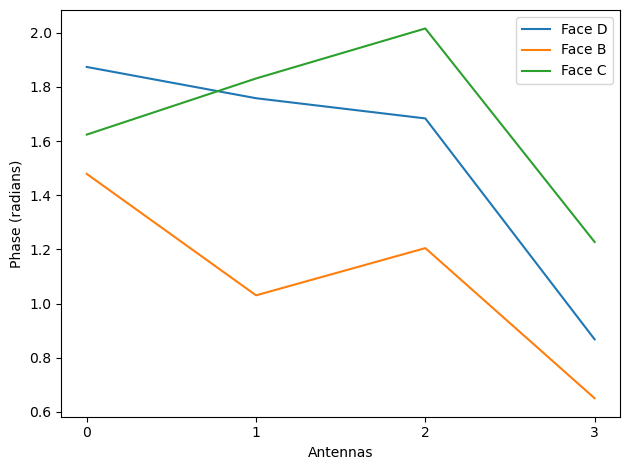

In [ ]:
frame_no = 12
plt.plot(phase_array_D[:][frame_no], label='Face D')
plt.plot(phase_array_B[:][frame_no], label='Face B')
plt.plot(phase_array_C[:][frame_no], label='Face C')
# plt.axhline(-np.pi/2, linestyle='-.', color='r', label="-pi/2")
# plt.axhline(np.pi/2, linestyle='-.', color='g', label="pi/2")
# plt.plot(phases, color='tab:orange', label="Expected phases")
# plt.plot(phase_array_2, label = 'Side C - Side D')
# plt.plot(phase_array_3, label = 'Side D - Side B')
plt.xlabel("Antennas")
plt.xticks([0, 1, 2, 3])
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()
plt.show()

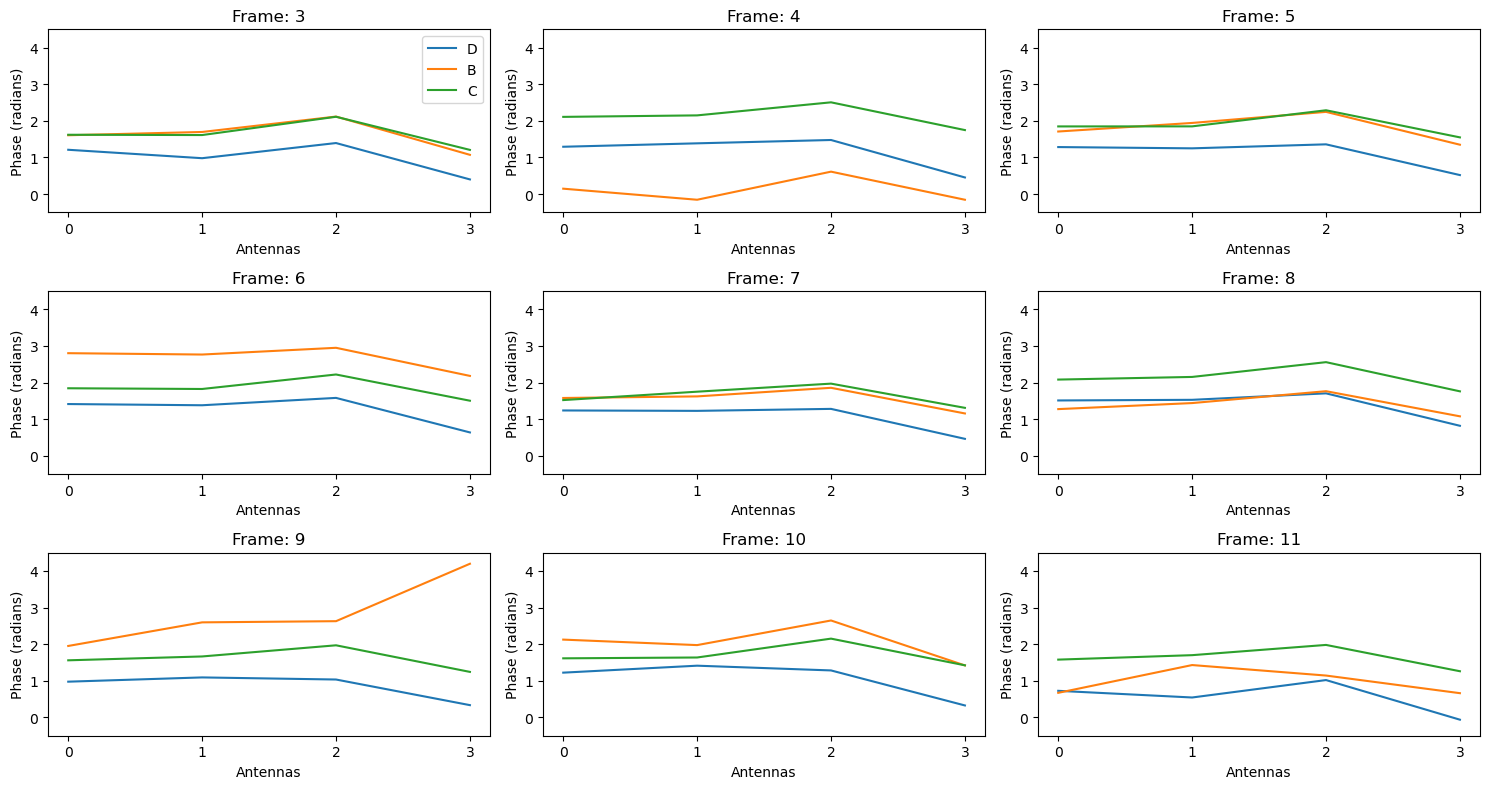

In [110]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(15, 8))

ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(9):
    ax[i].plot(phase_array_D[:][i], label='D')
    ax[i].plot(phase_array_B[:][i], label='B')
    ax[i].plot(phase_array_C[:][i], label='C')
    ax[i].set_xlabel("Antennas")
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_ylabel("Phase (radians)")
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_title(f"Frame: {i+3}")
    if i==0:
        ax[i].legend()

plt.tight_layout()
plt.show()
    

In [118]:
# Trying for the 200 cm H file 
filename = "/nas-data/soham/drone-landing/straight_200cm_H-24GHz.pickle"

phase_array_A = []
phase_array_B = []
phase_array_C = []
phase_array_D = []

for i in range(2, 15):
    phaseA, phaseB, phaseC, phaseD = get_del_r(filename, frame_no=i, f_tags = np.array([156, 250, 313, 625]))
    phase_array_A.append(phaseA)
    phase_array_B.append(phaseB)
    phase_array_C.append(phaseC)
    phase_array_D.append(phaseD)

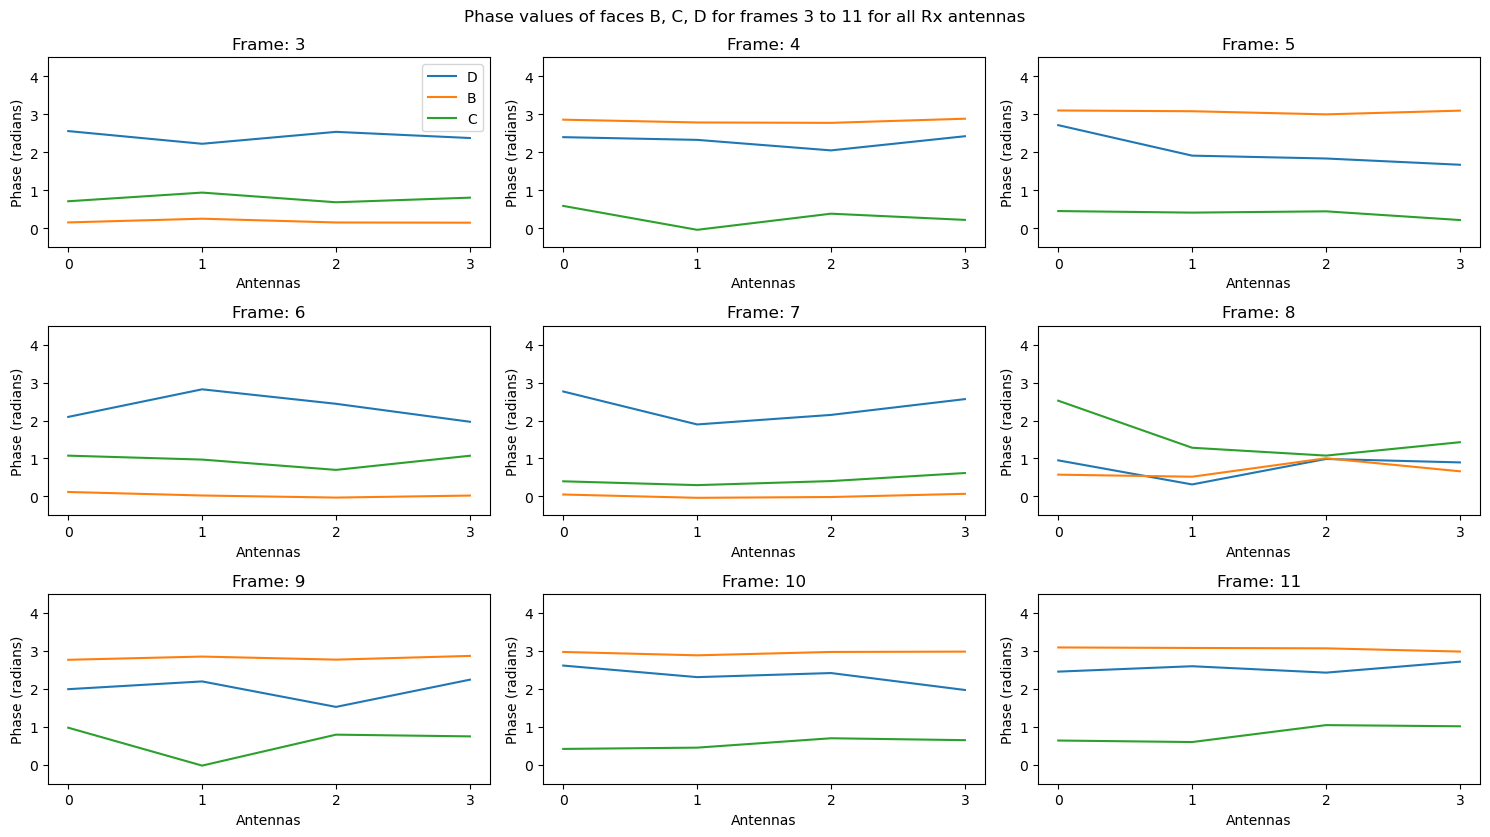

In [128]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(15, 8.5))

ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(9):
    ax[i].plot(phase_array_D[:][i], label='D')
    ax[i].plot(phase_array_B[:][i], label='B')
    ax[i].plot(phase_array_C[:][i], label='C')
    ax[i].set_xlabel("Antennas")
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_ylabel("Phase (radians)")
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_title(f"Frame: {i+3}")
    if i==0:
        ax[i].legend()

# plt.tight_layout()
plt.suptitle("Phase values of faces B, C, D for frames 3 to 11 for all Rx antennas")
plt.tight_layout()
plt.show()
    

In [130]:
phase_diff_DB = np.array(phase_array_D) - np.array(phase_array_B)
phase_diff_DC = np.array(phase_array_D) -  np.array(phase_array_C) 

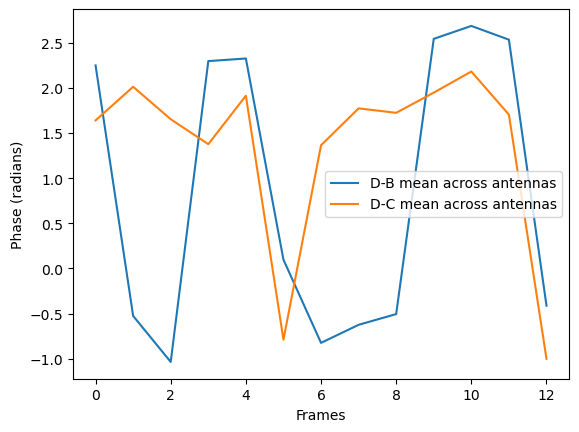

In [ ]:
plt.plot(np.mean(phase_diff_DB, axis=1), label='D-B mean across antennas')
plt.plot(np.mean(phase_diff_DC, axis=1), label='D-C mean across antennas')
plt.xlabel("Frames")
# plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
plt.ylabel("Phase (radians)")
plt.legend()
plt.show()

In [8]:
# what does this do? 
def get_period(Igrid, Fgrid, n_frames):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid, range_subset_width, n_frames):
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (n_frames, 1))

    period = get_period(Igrid, Qgrid, n_frames)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))

        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos -> why? 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return unwrapPi(angles)

In [151]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/straight_200cm_H-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
# f_tags = np.array([183, 337, 250, 127])
f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 50 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 0
side2 = 1
side3 = 2
side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

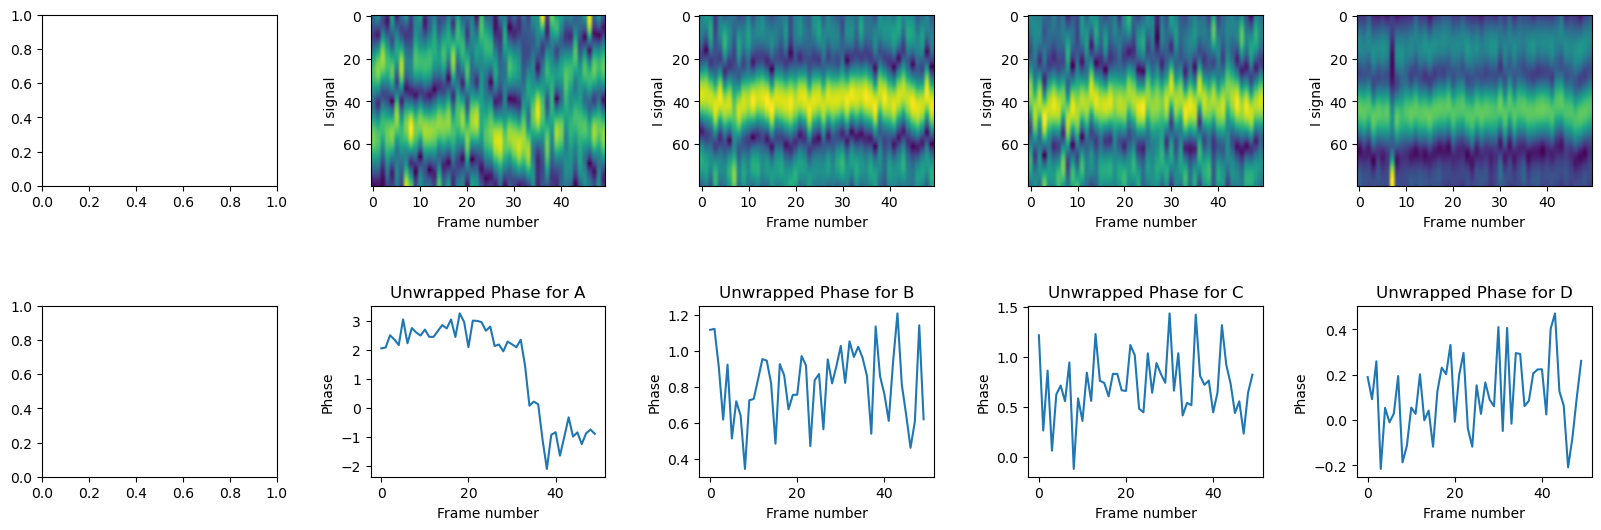

In [153]:
# Plots 

# Initialize plot

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20, 6))
plt.subplots_adjust(hspace= 0.7, wspace = 0.4)

# ax2.set_title("Phase over Frames \nMod Freq: " + str(modfreq1) + " Hz")
ax2.set_xlabel("Frame number")
ax2.set_ylabel("I signal")
ax2.imshow(Igrid[0], aspect='auto')

# ax3.set_title("Phase over Frames \nMod Freq: " + str(modfreq2) + " Hz")
ax3.set_xlabel("Frame number")
ax3.set_ylabel("I signal")
ax3.imshow(Igrid[1], aspect='auto')

# ax4.set_title("Phase over Frames \nMod Freq: " + str(modfreq3) + " Hz")
ax4.set_xlabel("Frame number")
ax4.set_ylabel("I signal")
ax4.imshow(Igrid[2], aspect='auto')

# ax5.set_title("Phase over Frames \nMod Freq: " + str(modfreq4) + " Hz")
ax5.set_xlabel("Frame number")
ax5.set_ylabel("I signal")
ax5.imshow(Igrid[3], aspect='auto')

ax7.set_title("Unwrapped Phase for A")
ax7.set_ylabel("Phase")
ax7.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax7.plot(phaseA)


ax8.set_title("Unwrapped Phase for B")
ax8.set_ylabel("Phase")
ax8.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax8.plot(phaseB)

ax9.set_title("Unwrapped Phase for C")
ax9.set_ylabel("Phase")
ax9.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax9.plot(phaseC)

ax10.set_title("Unwrapped Phase for D")
ax10.set_ylabel("Phase")
ax10.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax10.plot(phaseD)

plt.show()

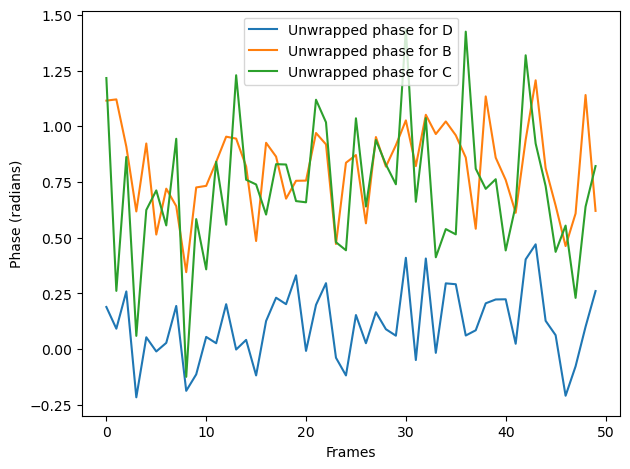

In [157]:
plt.plot(phaseD, label='Unwrapped phase for D')
plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()


In [158]:
phase_DB_framewise = phaseD - phaseB 
phase_DC_framewise = phaseD - phaseC

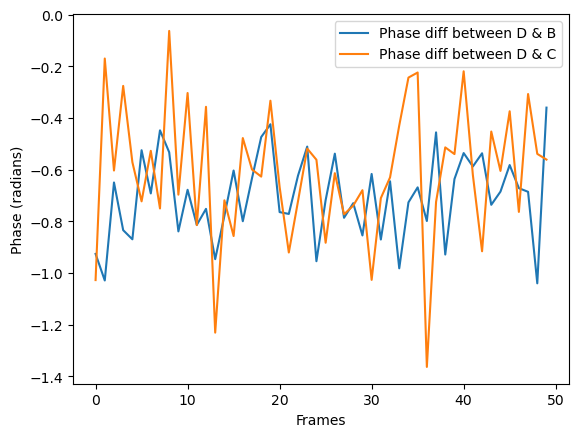

In [159]:
plt.plot(phase_DB_framewise, label='Phase diff between D & B')
plt.plot(phase_DC_framewise, label='Phase diff between D & C')
plt.xlabel("Frames")
# plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
plt.ylabel("Phase (radians)")
plt.legend()
plt.show()

In [160]:
print(np.mean(phase_DB_framewise))
print(np.mean(phase_DC_framewise))

-0.7048006038696022
-0.6111968507558942


In [163]:
(lam / (2*np.pi))*np.mean(phase_DB_framewise)

np.float64(-0.0013948911917098447)

In [164]:
h - lam/4

0.011891191709844559

In [ ]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 89 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

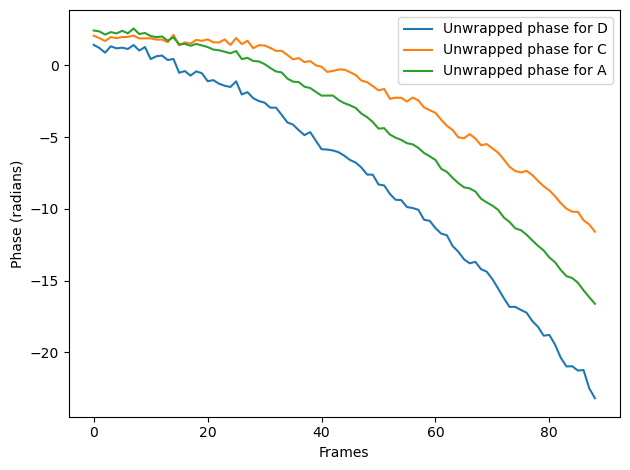

In [175]:
plt.plot(phaseD, label='Unwrapped phase for D')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseA, label='Unwrapped phase for A')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()


Text(0, 0.5, 'Unwrapped Phase (radians)')

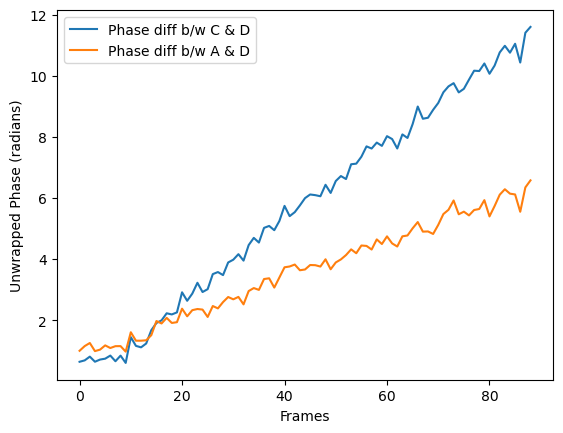

In [177]:
plt.plot(phaseC - phaseD, label="Phase diff b/w C & D")
plt.plot(phaseA - phaseD, label="Phase diff b/w A & D")
plt.legend()
plt.xlabel("Frames")
plt.ylabel("Unwrapped Phase (radians)")

In [9]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_0-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 89 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

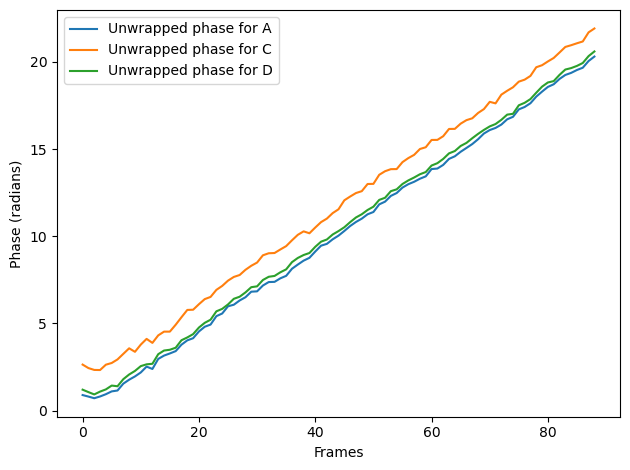

In [11]:
plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()


In [12]:
np.mean(phaseC - phaseA)

np.float64(1.5822243113072525)

In [13]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_15-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 89 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

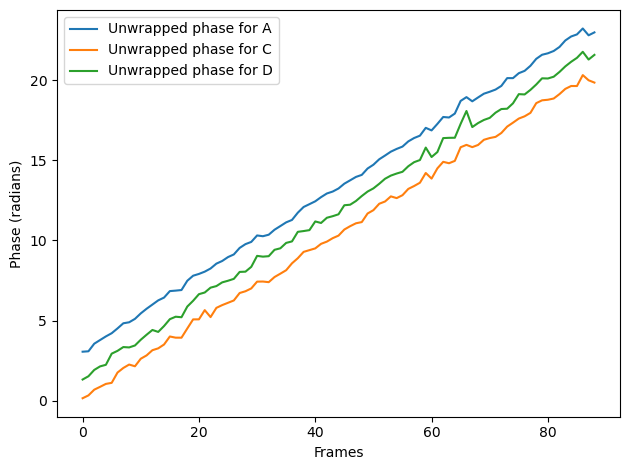

In [28]:
plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()

In [47]:
np.mean(phaseA - phaseD)

np.float64(1.5017607107021071)

In [30]:
np.mean(phaseD - phaseC)

np.float64(1.391884390112651)

In [37]:
# Trying to check if that's correct by emulating 
theta = 15 * np.pi/180
phi = 0
del_r1 = l*np.sin(a - phi + theta)*1e-3     
del_r2 = l*np.sin(a + phi - theta)*1e-3 

In [38]:
print(del_r1)
print(del_r2)

0.02189103696968983
0.003808385564557118


In [ ]:
del_phi1 = del_r1*(4*np.pi/lam)
del_phi2 = del_r2*(4*np.pi/lam)
print(del_phi1)
print(del_phi2)

22.29343906444402
3.87839149122616


In [50]:
del_phi1 % np.pi

np.float64(0.3022904893154674)

In [51]:
del_phi2 % np.pi

np.float64(0.7367988376363668)

In [18]:
# Tag dimensions 
y1 = -1.304 
y2 = -36.237 
z1 = 28.671 
z2 = 15.368 

a = np.atan((z2-z1)/(y2-y1))
a

np.float64(0.36385872084832616)

In [17]:
a*180/np.pi

np.float64(20.847569043637865)

In [19]:
l = np.sqrt((y2-y1)**2 + (z2-z1)**2)
l

np.float64(37.3802661574259)

In [21]:
lam = c/(24.15e9)

In [22]:
lam

0.012339544513457557

In [25]:
# when theta = 0 to 8, phi = 0, we can plot the changes in del_r's
thetas = np.linspace(0, 8, 87)*np.pi/180
phi = 0 
del_r1s = l*np.sin(a - phi + thetas)
del_r2s = l*np.sin(a + phi - thetas)

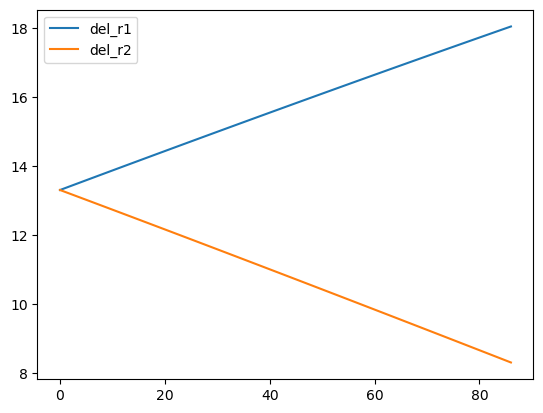

In [27]:
plt.plot(del_r1s, label='del_r1')
plt.plot(del_r2s, label='del_r2')
plt.legend()

In [52]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_30-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 89 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

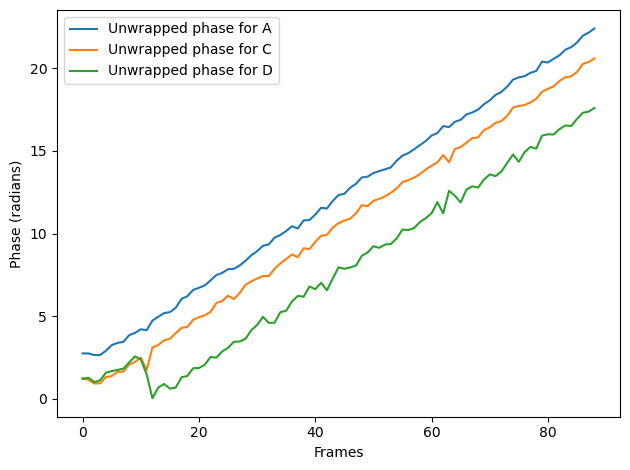

In [53]:
plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()

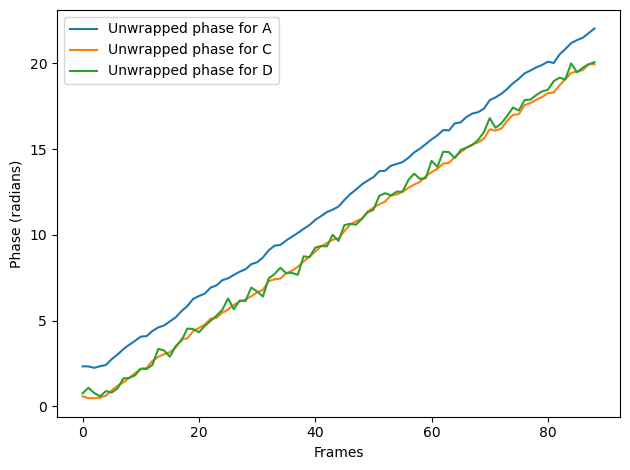

In [56]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_45-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 89 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()

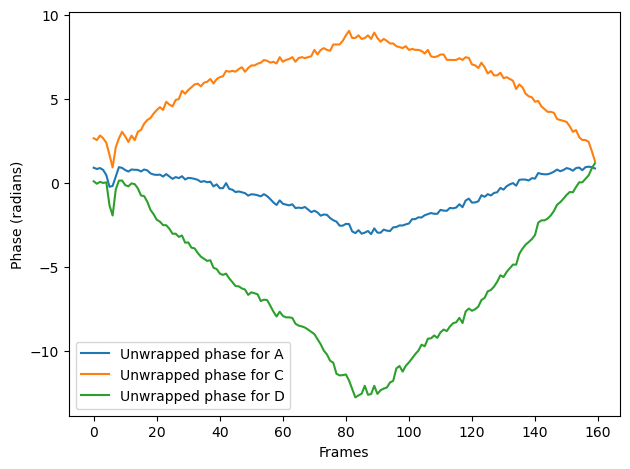

In [60]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 160 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()

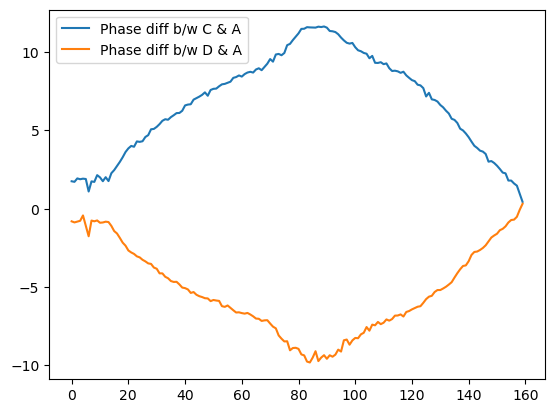

In [61]:
plt.plot(phaseC - phaseA , label = "Phase diff b/w C & A")
plt.plot(phaseD - phaseA , label = "Phase diff b/w D & A")
plt.legend()

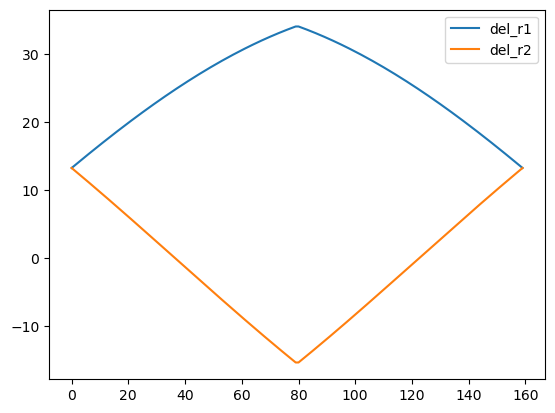

In [72]:
theta0_45 = np.linspace(0, 45, 80)*np.pi/180
theta45_0 = np.linspace(45, 0, 80)*np.pi/180
thetas = np.concatenate((theta0_45, theta45_0))
phi = 0 
del_r1s = l*np.sin(a - phi + thetas)
del_r2s = l*np.sin(a + phi - thetas)

plt.plot(del_r1s, label='del_r1')
plt.plot(del_r2s, label='del_r2')
plt.legend()